In [1]:
from sklearn.utils.multiclass import type_of_target

In [2]:
type_of_target([0,1])

'binary'

In [3]:
type_of_target([1,-1])

'binary'

In [4]:
type_of_target([0,1,2])

'multiclass'

In [5]:
type_of_target([1, 2.1, 3.4])

'continuous'

In [6]:
type_of_target([[-1,1],[1,-1]])

'multilabel-indicator'

In [7]:
type_of_target([[0,1],[1,1],[1,0]])

'multilabel-indicator'

In [8]:
type_of_target([[0,1,2],[0,1,2]])

'multiclass-multioutput'

In [9]:
type_of_target([[0,1],[0,2]])

'multiclass-multioutput'

In [10]:
type_of_target([[-1.2,1],[1,-1.2]])

'continuous-multioutput'

### Predict digit from image

In [11]:
import numpy as np
import os
import io
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import hinge_loss, ConfusionMatrixDisplay, confusion_matrix, make_scorer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, classification_report
from sklearn.model_selection import cross_validate, cross_val_predict, GridSearchCV
from pprint import pprint

# warnings.filterwarnings("ignore")

To start with, we will treat this as a binary classification problem - whether the image represents a 0 or not.

In [12]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [13]:
if not isinstance(X, np.ndarray):
    X = X.to_numpy()
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
if not isinstance(y, np.ndarray):
    y = y.to_numpy()
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [15]:
target_names = np.unique(y)
print(f'Number of samples: {X.shape[0]}, type: {X.dtype}')
print(f'Number of features: {X.shape[1]}')
print(f'Minimum: {np.min(X)}, Maximum: {np.max(X)}')
print(f'Number of classes: {len(target_names)}, type: {y.dtype}')
print(f'Labels: {target_names}')

Number of samples: 70000, type: float64
Number of features: 784
Minimum: 0.0, Maximum: 255.0
Number of classes: 10, type: object
Labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


#### Data Scaling

In [16]:
X = MinMaxScaler().fit_transform(X)
print(f'Minimum: {np.min(X)}, Maximum: {np.max(X)}')

Minimum: 0.0, Maximum: 1.0


Label: 5


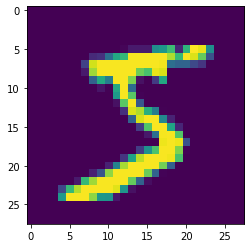

In [17]:
print(f'Label: {y[0]}')
plt.imshow(X[0].reshape(28, 28))

Label: 0


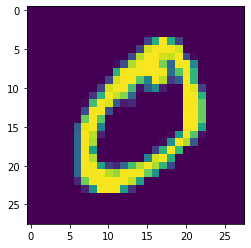

In [18]:
print(f'Label: {y[1]}')
plt.imshow(X[1].reshape(28, 28))

Label: 3


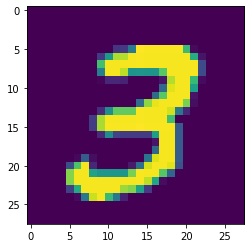

In [19]:
print(f'Label: {y[7]}')
plt.imshow(X[7].reshape(28, 28))

In [20]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Check if there's any class imbalance, using histogram

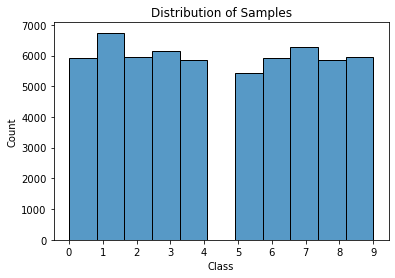

In [21]:
sns.histplot(data=np.int8(y_train), bins=11)
plt.xticks(ticks=np.arange(10), labels=np.arange(10))
plt.xlabel('Class')
plt.title('Distribution of Samples')
plt.show()

#### Binary classification

To convert this to a binary classification problem, all zero labels are being converted to 1 and non-zero labels to -1

In [22]:
#initialize new variable names with all -1
y_train_0 = -1 * np.ones(y_train.shape[0])
y_test_0 = -1 * np.ones(y_test.shape[0])

#find indices of digit 0 image
indx_0 = np.where(y_train == '0')
y_train_0[indx_0] = 1
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

Randomly check some images from the training set and check what're they labelled as.

Label: -1.0


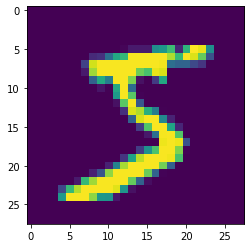

In [23]:
print(f'Label: {y_train_0[0]}')
plt.imshow(X_train[0].reshape(28, 28))

Label: 1.0


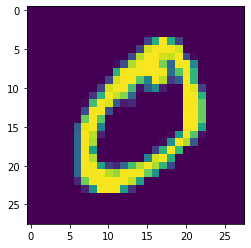

In [24]:
print(f'Label: {y_train_0[1]}')
plt.imshow(X_train[1].reshape(28, 28))

Label: -1.0


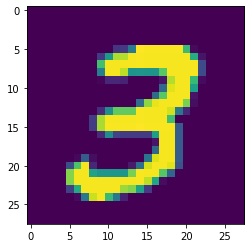

In [25]:
print(f'Label: {y_train_0[7]}')
plt.imshow(X_train[7].reshape(28, 28))

Notice from the above images that all 0's have been labelled 1, and non-0's have been labelled -1.

In [26]:
y_train_0

array([-1.,  1., -1., ..., -1., -1., -1.])

In [27]:
np.where(y_train_0 == 1) # return a tuple with all indexes where the values are 1

(array([    1,    21,    34, ..., 59952, 59972, 59987], dtype=int64),)

In [28]:
len(np.where(y_train_0 == 1)[0])

5923

In [29]:
len(np.where(y_train_0 == -1)[0])

54077

#### Dummy classifier

In [30]:
base_clf = DummyClassifier(strategy='most_frequent')
base_clf.fit(X_train, y_train_0)
print(f'Training accuracy: {base_clf.score(X_train, y_train_0):.2f}')
print(f'Testing accuracy: {base_clf.score(X_test, y_test_0):.2f}')

Training accuracy: 0.90
Testing accuracy: 0.90


#### Perceptron model

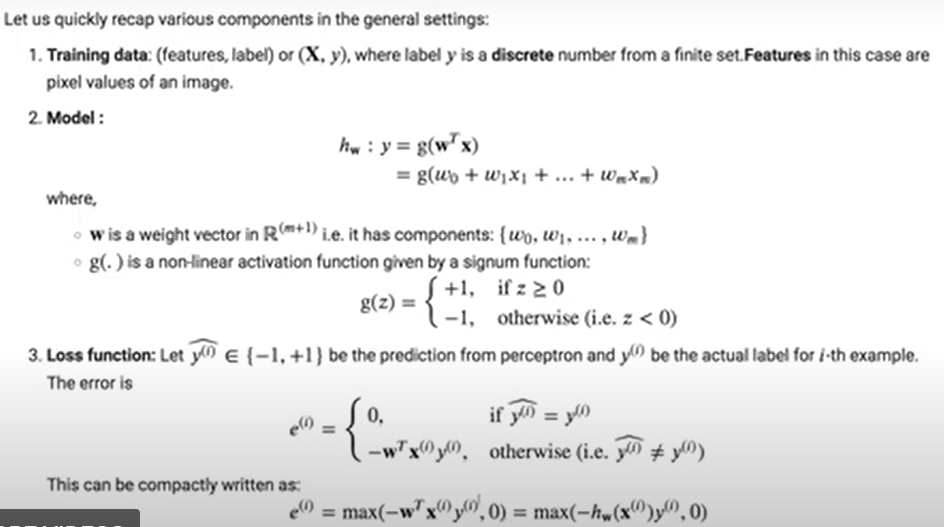

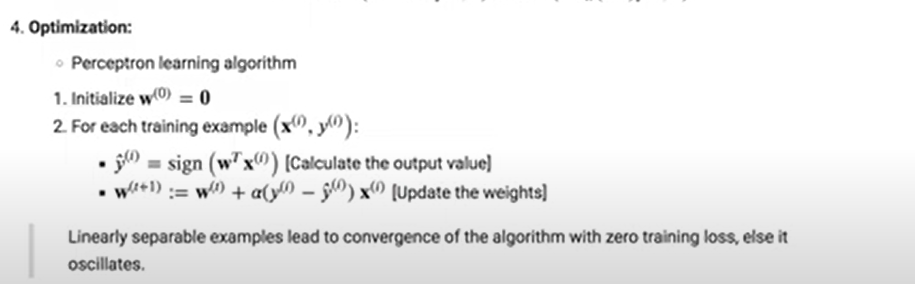

In [31]:
X.shape

(70000, 784)

In [32]:
bin_clf = Perceptron(max_iter=100, random_state=1729)
bin_clf.fit(X_train, y_train_0)
print(f'Dimension of weights: {bin_clf.coef_.shape}')
print(f'Bias: {bin_clf.intercept_}')
print(f'Loss function: {bin_clf.loss_function_}, loss value: {bin_clf.loss}')

Dimension of weights: (1, 784)
Bias: [-108.]
Loss function: <sklearn.linear_model._sgd_fast.Hinge object at 0x00000264EC9D0910>, loss value: perceptron


In [33]:
y_hat_train_0 = bin_clf.predict(X_train)
len(np.where(y_hat_train_0 == 1)[0])

5624

In [34]:
print(f'Training accuracy is {bin_clf.score(X_train, y_train_0)}')

Training accuracy is 0.99095


In [35]:
y_hat_test_0 = bin_clf.predict(X_test)
len(np.where(y_hat_test_0 == 1)[0])

932

In [36]:
print(f'Test accuracy is {bin_clf.score(X_test, y_test_0)}')

Test accuracy is 0.989


#### Predictions

The following indices from x_test have been predicted as 0.  # Note 0 has been translated to 1 earlier.

In [37]:
np.where(bin_clf.predict(X_test) == 1)[0]

array([   3,   10,   13,   25,   28,   55,   69,   71,  101,  136,  148,
        157,  183,  188,  192,  194,  215,  246,  259,  269,  271,  294,
        296,  297,  311,  312,  327,  346,  365,  372,  380,  407,  424,
        440,  441,  445,  459,  485,  490,  498,  525,  545,  546,  561,
        564,  567,  581,  586,  592,  597,  611,  620,  642,  644,  661,
        701,  704,  723,  742,  750,  763,  794,  804,  821,  845,  851,
        854,  871,  884,  895,  904,  965,  972,  981,  993,  995,  997,
       1001, 1009, 1034, 1047, 1061, 1084, 1094, 1121, 1148, 1154, 1176,
       1188, 1195, 1197, 1203, 1218, 1220, 1223, 1231, 1246, 1261, 1273,
       1288, 1294, 1297, 1333, 1352, 1379, 1390, 1399, 1404, 1408, 1411,
       1416, 1438, 1445, 1454, 1457, 1487, 1504, 1517, 1526, 1533, 1534,
       1535, 1558, 1565, 1589, 1590, 1610, 1619, 1621, 1623, 1638, 1650,
       1700, 1708, 1713, 1717, 1723, 1726, 1739, 1748, 1757, 1762, 1764,
       1768, 1775, 1777, 1807, 1808, 1826, 1841, 18

Randomly check some indices if they are actually 0's.  In 98.9% cases, they should be.

Label: 1.0


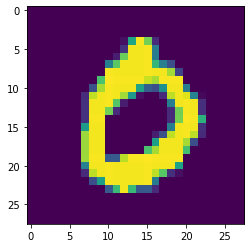

In [38]:
print(f'Label: {y_test_0[3]}')
plt.imshow(X_test[3].reshape(28, 28))

Label: 1.0


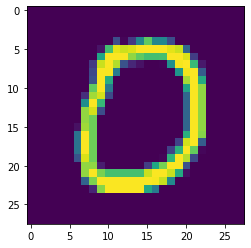

In [39]:
print(f'Label: {y_test_0[10]}')
plt.imshow(X_test[10].reshape(28, 28))

Let's see how many 0's have been correctly predicted.

In [40]:
idx_0 = np.where(y_test_0 == 1)[0] #all images from test set that are actually 0's

In [41]:
zero_imgs = X_test[idx_0] # all images for the actual 0's.
zero_pred_labels = y_hat_test_0[idx_0] # predictions of all actual 0's

In [42]:
num_misclassified = np.count_nonzero(zero_pred_labels == -1)
num_correctpred = len(zero_pred_labels) - num_misclassified
accuracy = num_correctpred / len(zero_pred_labels)
print(accuracy)

0.9193877551020408


Let's see how many non-0's have been correctly predicted.

In [43]:
idx_not_0 = np.where(y_test_0 == -1)[0] #all images from test set that are actually non-0's

In [44]:
idx_not_0

array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=int64)

In [45]:
non_zero_imgs = X_test[idx_not_0] # all images for the actual non-0's.
non_zero_pred_labels = y_hat_test_0[idx_not_0] # predictions of all actual non_0's

In [46]:
non_zero_pred_labels

array([-1., -1., -1., ..., -1., -1., -1.])

In [47]:
num_misclassified = np.count_nonzero(non_zero_pred_labels == 1)
num_correctpred = len(non_zero_pred_labels) - num_misclassified
accuracy = num_correctpred / len(non_zero_pred_labels)
print(accuracy)

0.9965631929046563


#### Confusion Matrix

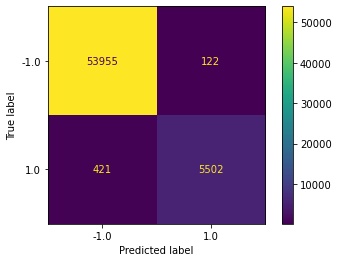

In [48]:
y_hat_train_0 = bin_clf.predict(X_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='.5g')

In [49]:
(53955+5502)/(53955+5502+122+421)

0.99095

In [50]:
cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0, 0]
fn = cf_matrix[1, 0]
fp = cf_matrix[0, 1]
tp = cf_matrix[1, 1]

precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tn + tp) / (tp + fp + tn + fn)
print(f"Precision: {precision}, Recall: {recall}, Acccuracy: {accuracy}")

Precision: 0.9783072546230441, Recall: 0.9289211548201924, Acccuracy: 0.99095


In [51]:
bin_cfg = Perceptron(max_iter=100, random_state=1729)
scores = cross_validate(bin_clf, X_train, y_train_0, cv=5, scoring=['recall', 'f1', 'precision'], return_estimator=True)
# scores = cross_validate(bin_clf, X_test, y_test_0, cv=5, scoring=['recall', 'f1', 'precision'], return_estimator=True)
pprint(scores)

{'estimator': [Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729)],
 'fit_time': array([0.8778429 , 1.72772264, 1.22421861, 1.13545179, 1.40786123]),
 'score_time': array([0.03124213, 0.03124237, 0.03124332, 0.0312438 , 0.03128409]),
 'test_f1': array([0.95238095, 0.91666667, 0.94915254, 0.94117647, 0.95091763]),
 'test_precision': array([0.95890411, 0.98828125, 0.95319149, 0.95090439, 0.96200345]),
 'test_recall': array([0.94594595, 0.85472973, 0.94514768, 0.93164557, 0.94008439])}


In [52]:
print(scores['test_f1'].mean(), scores['test_f1'].std())
print(scores['test_precision'].mean(), scores['test_precision'].std())
print(scores['test_recall'].mean(), scores['test_recall'].std())

0.94205885179654 0.013273174197442695
0.9626569391894069 0.01340770796981747
0.9235106625612953 0.03476545483691418


Let's look at the first estimator returned from the above function

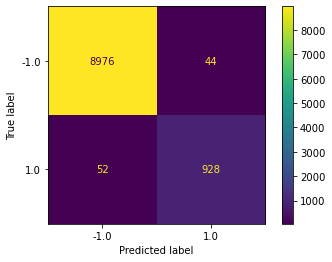

In [53]:
bin_clf = scores['estimator'][0]
y_hat_test_0 = bin_clf.predict(X_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, y_hat_test_0, values_format='.5g')

In [54]:
precision_score(y_test_0, y_hat_test_0)

0.9547325102880658

In [55]:
recall_score(y_test_0, y_hat_test_0)

0.9469387755102041

Alternatively,

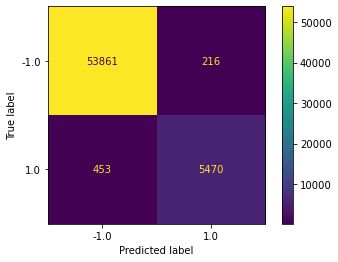

In [56]:
y_hat_train_0 = cross_val_predict(bin_clf, X_train, y_train_0, cv=5)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='.5g')

In [57]:
cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0, 0]
fn = cf_matrix[1, 0]
fp = cf_matrix[0, 1]
tp = cf_matrix[1, 1]

precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tn + tp) / (tp + fp + tn + fn)
print(f"Precision: {precision}, Recall: {recall}, Acccuracy: {accuracy}")

Precision: 0.9620119591980303, Recall: 0.9235184872530812, Acccuracy: 0.98885


In [58]:
print(classification_report(y_train_0, y_hat_train_0))

              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99     54077
         1.0       0.96      0.92      0.94      5923

    accuracy                           0.99     60000
   macro avg       0.98      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



#### Precision-recall curve

<AxesSubplot:ylabel='Count'>

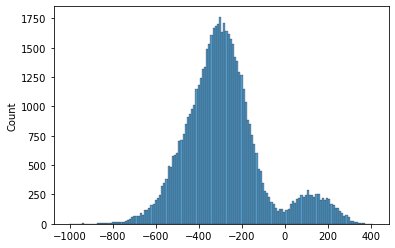

In [59]:
bin_clf = Perceptron(random_state=1729)
bin_clf.fit(X_train, y_train_0)
y_scores = bin_clf.decision_function(X_train)  #non-linear function h(x)
sns.histplot(np.sort(y_scores))

Note that there's small number of positive values, which implies that 0's are lesser than non-0's.

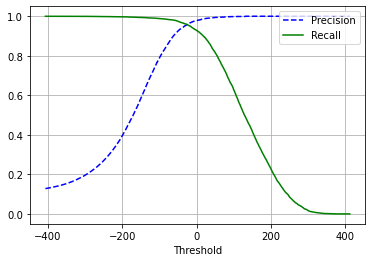

In [60]:
precisions, recalls, thresholds = precision_recall_curve(y_train_0, y_scores, pos_label=1)
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

In [61]:
# get the index of the threshold around 0
idx_th = np.where(np.logical_and(thresholds>0, thresholds<1))
print(f'Precision for zero threshold: {precisions[idx_th[0][0]]}')

Precision for zero threshold: 0.9783072546230441


In [62]:
bin_clf.fit(X_train, y_train_0)
y_hat_train_0 = bin_clf.predict(X_train)
print(f'Training accuracy: {bin_clf.score(X_train, y_train_0)}')
print(f'Test accuracy: {bin_clf.score(X_test, y_test_0)}')

Training accuracy: 0.99095
Test accuracy: 0.989


In [63]:
bin_clf_warm = Perceptron(max_iter=1, random_state=1720, warm_start=True)

In [64]:
bin_clf_warm.fit(X_train, y_train_0)
y_hat_train_0 = bin_clf.predict(X_train)
print(f'Training accuracy: {bin_clf.score(X_train, y_train_0)}')
print(f'Test accuracy: {bin_clf.score(X_test, y_test_0)}')

Training accuracy: 0.99095
Test accuracy: 0.989


D:\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


#### Multil-class classification

In [65]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [66]:
if not isinstance(X, np.ndarray):
    X = X.to_numpy()
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [67]:
if not isinstance(y, np.ndarray):
    y = y.to_numpy()
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [68]:
target_names = np.unique(y)
print(f'Number of samples: {X.shape[0]}, type: {X.dtype}')
print(f'Number of features: {X.shape[1]}')
print(f'Minimum: {np.min(X)}, Maximum: {np.max(X)}')
print(f'Number of classes: {len(target_names)}, type: {y.dtype}')
print(f'Labels: {target_names}')

Number of samples: 70000, type: float64
Number of features: 784
Minimum: 0.0, Maximum: 255.0
Number of classes: 10, type: object
Labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [69]:
#This step is internal to the algorithm, and shown here only for clarity
from sklearn.preprocessing import LabelBinarizer
y_train_ovr = LabelBinarizer().fit_transform(y_train)
# see the equivalent conversions for the first 10 y_train values
for i in range(10):
    print(y_train[i], '==>', y_train_ovr[i])

5 ==> [0 0 0 0 0 1 0 0 0 0]
0 ==> [1 0 0 0 0 0 0 0 0 0]
4 ==> [0 0 0 0 1 0 0 0 0 0]
1 ==> [0 1 0 0 0 0 0 0 0 0]
9 ==> [0 0 0 0 0 0 0 0 0 1]
2 ==> [0 0 1 0 0 0 0 0 0 0]
1 ==> [0 1 0 0 0 0 0 0 0 0]
3 ==> [0 0 0 1 0 0 0 0 0 0]
1 ==> [0 1 0 0 0 0 0 0 0 0]
4 ==> [0 0 0 0 1 0 0 0 0 0]


In [70]:
y_train_ovr.shape

(60000, 10)

Note that the first column of y_train is the 0-detector, second column is the 1-detector and so on.

Now, split the dataset into train and test data

In [71]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [72]:
clf = Perceptron(random_state=1729)
clf.fit(X_train, y_train)

Perceptron(random_state=1729)

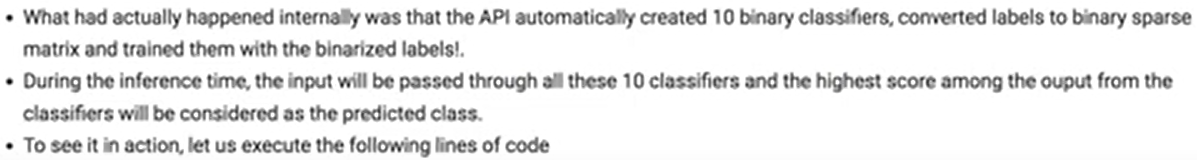

In [73]:
print(f"Shape of weight matrix is {clf.coef_.shape} and shape of bias vector is {clf.intercept_.shape}")

Shape of weight matrix is (10, 784) and shape of bias vector is (10,)


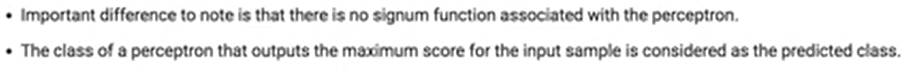

In [74]:
scores = clf.decision_function(X_train[0].reshape(1, -1))
print(scores)
print(f"Predicted class is {np.argmax(scores)}")

[[-12002266. -17622609. -13573128.    857820. -20312887.   3197840.
  -18155723.  -9888472. -13008226. -12868963.]]
Predicted class is 5


In [75]:
clf.predict(X_train[0].reshape(1, -1))

array(['5'], dtype='<U1')

In [76]:
y_hat_train = clf.predict(X_train) #Get predictions for all examples in X_train

In [77]:
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      5923
           1       0.92      0.98      0.95      6742
           2       0.92      0.88      0.90      5958
           3       0.85      0.91      0.88      6131
           4       0.85      0.93      0.89      5842
           5       0.89      0.81      0.84      5421
           6       0.96      0.94      0.95      5918
           7       0.96      0.88      0.92      6265
           8       0.81      0.82      0.81      5851
           9       0.87      0.85      0.86      5949

    accuracy                           0.90     60000
   macro avg       0.90      0.90      0.90     60000
weighted avg       0.90      0.90      0.90     60000



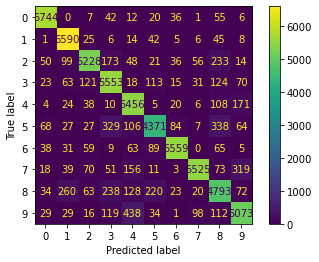

In [78]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_train, y_hat_train, values_format='.5g')

There seems to confusion between 1/5, 1/8, 7/4 etc.

##### Making a pipeline

In [79]:
pipe = Pipeline([('std_scaler', MinMaxScaler()),
                ('clf', Perceptron(random_state=1729))])

In [80]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('std_scaler', MinMaxScaler()),
                ('clf', Perceptron(random_state=1729))])

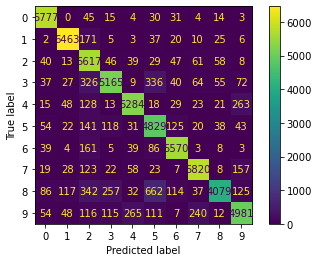

In [81]:
y_hat_train = pipe.predict(X_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train, y_hat_train, values_format='.5g')

#### GridSearchCV

In [82]:
y_train = y_train.astype(float)

First convert this to a binary classification problem, all zero labels are being converted to 1 and non-zero labels to -1

In [83]:
#initialize new variable names with all -1
y_train_0 = -1 * np.ones(y_train.shape[0])
y_test_0 = -1 * np.ones(y_test.shape[0])

#find indices of digit 0 image
indx_0 = np.where(y_train == 0)
y_train_0[indx_0] = 1
indx_0 = np.where(y_test == 0)
y_test_0[indx_0] = 1

In [84]:
pipe = Pipeline([('std_scaler', MinMaxScaler()),
                ('clf', Perceptron(random_state=1729))])

scoring = make_scorer(hinge_loss, greater_is_better=False)
lr_grid = [1/2 ** n for n in range(1,6)]
bin_clf_gscv = GridSearchCV(pipe, param_grid={"clf__eta0": lr_grid}, scoring=scoring, cv=5)
bin_clf_gscv.fit(X_train, y_train_0)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('std_scaler', MinMaxScaler()),
                                       ('clf', Perceptron(random_state=1729))]),
             param_grid={'clf__eta0': [0.5, 0.25, 0.125, 0.0625, 0.03125]},
             scoring=make_scorer(hinge_loss, greater_is_better=False))

In [85]:
pprint(bin_clf_gscv.cv_results_)

{'mean_fit_time': array([1.70929518, 1.66976113, 1.44048109, 1.29778385, 1.17765203]),
 'mean_score_time': array([0.09895139, 0.08652582, 0.09685326, 0.08444271, 0.09359426]),
 'mean_test_score': array([-0.01983333, -0.01963333, -0.0206    , -0.0229    , -0.02413333]),
 'param_clf__eta0': masked_array(data=[0.5, 0.25, 0.125, 0.0625, 0.03125],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'clf__eta0': 0.5},
            {'clf__eta0': 0.25},
            {'clf__eta0': 0.125},
            {'clf__eta0': 0.0625},
            {'clf__eta0': 0.03125}],
 'rank_test_score': array([2, 1, 3, 4, 5]),
 'split0_test_score': array([-0.01916667, -0.01916667, -0.01916667, -0.02      , -0.02316667]),
 'split1_test_score': array([-0.01983333, -0.01983333, -0.01983333, -0.02783333, -0.02783333]),
 'split2_test_score': array([-0.01916667, -0.01916667, -0.02066667, -0.02066667, -0.0185    ]),
 'split3_test_score': array([-0.01983333, -0.01

In [86]:
bin_clf_gscv.best_params_

{'clf__eta0': 0.25}